Last updated 2020-02-03

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import shap

from clf_eval_utils.clf_eval_utils import quickplot_eval_3, plot_decision_curve, quickplot_eval_4
from shap_wrapper_utils.shap_wrappers import dep_plot, get_shap_categories, plot_shap_summary_bar

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
data_path = Path('.','data')
output_path = Path('.','images')

# Load NHFES data

Available for download at https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv

In [2]:
full_data = pd.read_csv(data_path / 'nhefs.csv')
full_data.drop(['seqn','yrdth','modth','dadth'], axis=1, inplace=True)
full_data.dropna(axis=1,inplace=True)
full_data.head()

,qsmk,death,sex,age,race,marital,school,education,ht,wt71,...,allergies,nerves,lackpep,hbpmed,boweltrouble,wtloss,infection,active,exercise,birthcontrol
0,0,0,0,42,1,2,7,1,174.1875,79.04,...,0,0,0,1,0,0,0,0,2,2
1,0,0,0,36,0,2,9,2,159.3750,58.63,...,0,0,0,0,0,0,1,0,0,2
2,0,0,1,56,1,3,11,2,168.5000,56.81,...,0,1,0,0,0,0,0,0,2,0
3,0,1,0,68,1,3,5,1,170.1875,59.42,...,0,0,0,0,0,0,0,1,2,2
4,0,0,0,40,0,2,11,2,181.8750,87.09,...,0,0,0,0,1,0,0,1,1,2


In [3]:
data_desc = pd.read_excel(data_path / 'NHEFS_Codebook.xls')
data_desc_dict = pd.Series(index=data_desc['Variable name'], data=data_desc['Description'].values).to_dict()
data_desc.head()

,Variable name,Description,Category
0,active,"IN YOUR USUAL DAY, HOW ACTIVE ARE YOU? IN 1971...",Lifestyle
1,age,AGE IN 1971,Base features
2,alcoholfreq,HOW OFTEN DO YOU DRINK? IN 1971 0: Almost ev...,Lifestyle
3,alcoholhowmuch,"WHEN YOU DRINK, HOW MUCH DO YOU DRINK? IN 1971",Lifestyle
4,alcoholpy,"HAVE YOU HAD 1 DRINK PAST YEAR? IN 1971, 1:EV...",Lifestyle


In [4]:
data_desc.Category.value_counts()

Diagnoses          16
Socioeconomic      12
Medications        11
Lifestyle          11
Anthropometrics     6
Outcome             4
Base features       3
ID                  1
Name: Category, dtype: int64

# Split train\test

In [5]:
data_train, data_test = train_test_split(full_data, test_size=0.3)
print(f'Train: {data_train.shape}, Test: {data_test.shape}')\

X_train, y_train = data_train.loc[:, data_train.columns!='death'], data_train.loc[:, 'death']
X_test, y_test = data_test.loc[:, data_test.columns!='death'], data_test.loc[:, 'death']

Train: (1140, 44), Test: (489, 44)


# Fit and Predict

In [24]:
clf = GradientBoostingClassifier(n_estimators=600, learning_rate=0.01,
    max_depth=3, random_state=0).fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

print(f'Train AUC: {roc_auc_score(y_train,y_pred_train)}')
print(f'Test AUC: {roc_auc_score(y_test,y_pred_test)}')

Train AUC: 0.9330851800554016
Test AUC: 0.8346700083542189


# Classification evaluation plots

## On train set - ROC, PR and Calibration plots

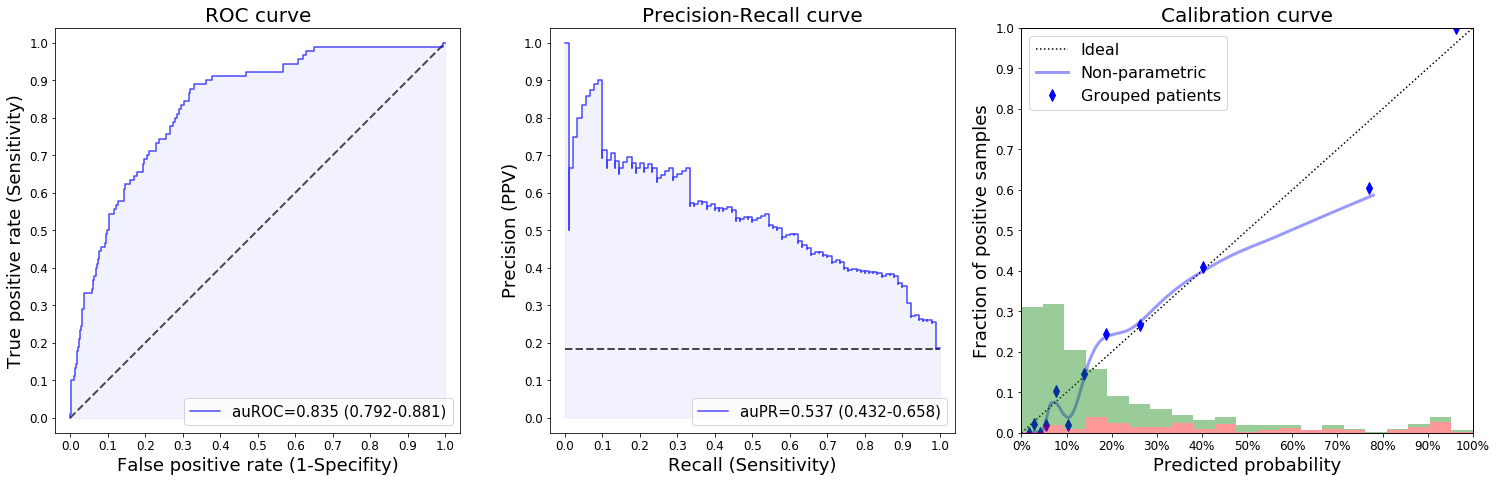

In [25]:
# y_true = y_train
# y_pred = y_pred_train
y_true = y_test
y_pred = y_pred_test

quickplot_eval_3(y_true, y_pred)
fig = plt.gcf()
fig.tight_layout()
fig.savefig(output_path / 'example_eval_plots.png')

## Net Benefit (Decision Curve Analysis - DCA) plot

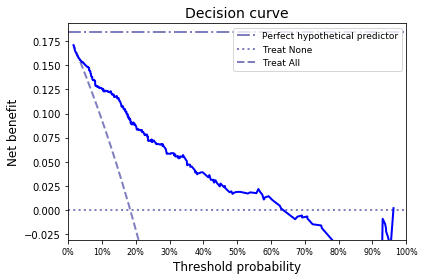

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
plot_decision_curve(y_true,y_pred, ax=ax, sz=12)
fig.tight_layout()
fig.savefig(output_path / 'example_DCA.png')

## ROC, PR, Calibration and DCA plots

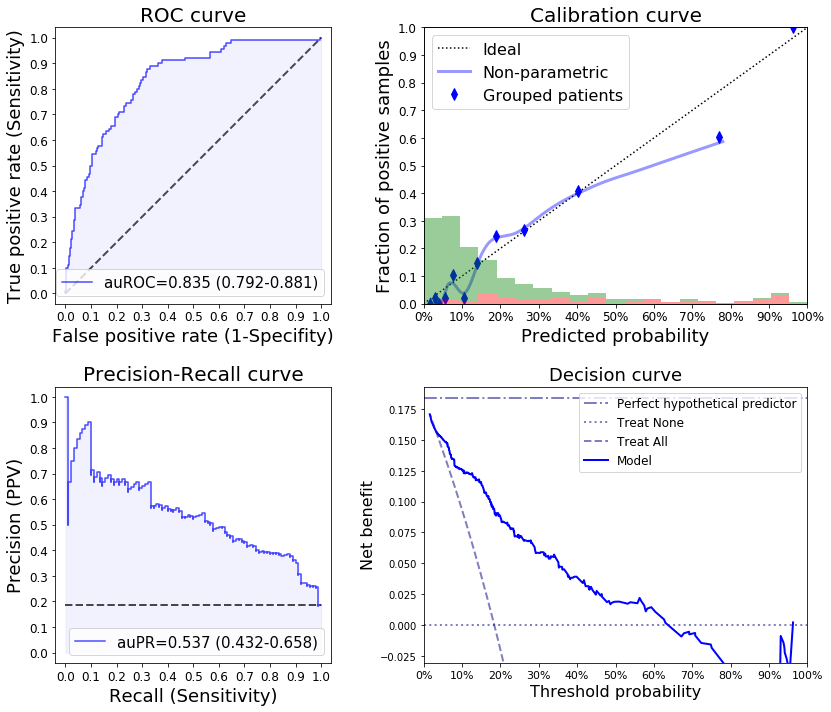

In [27]:
quickplot_eval_4(y_true, y_pred)

# simple SHAP

In [28]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


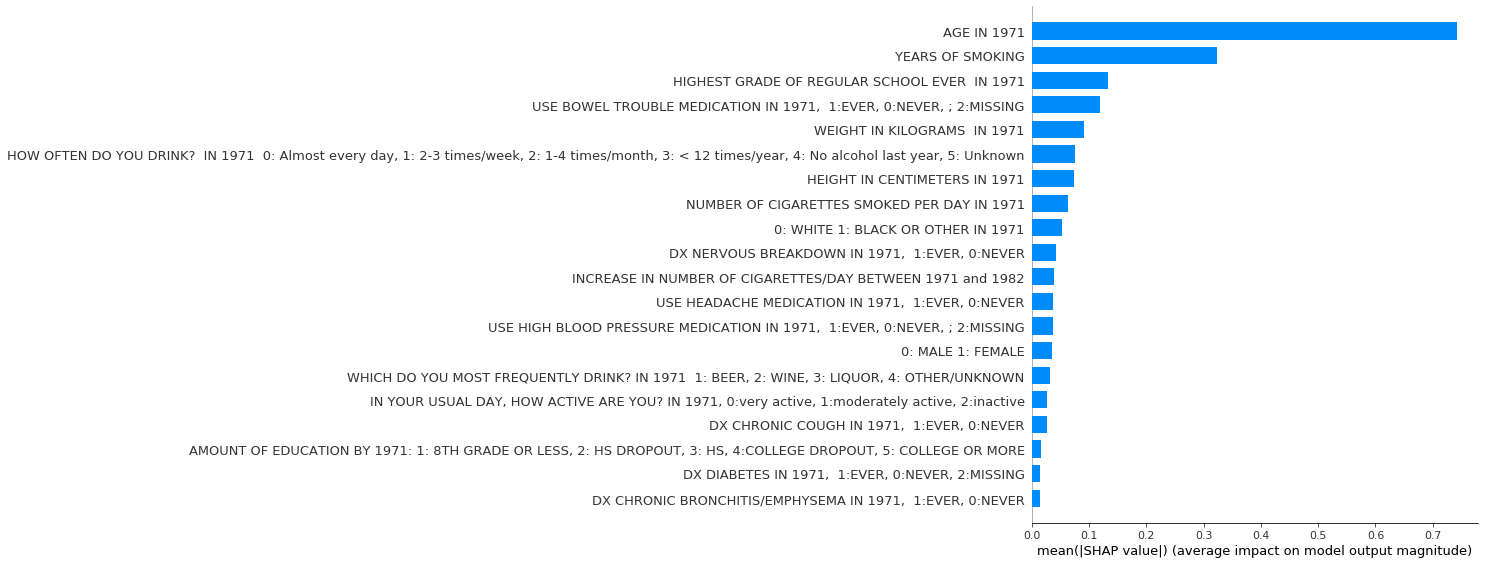

In [29]:
shap.summary_plot(shap_values, X_train.rename(columns=data_desc_dict), plot_type='bar')

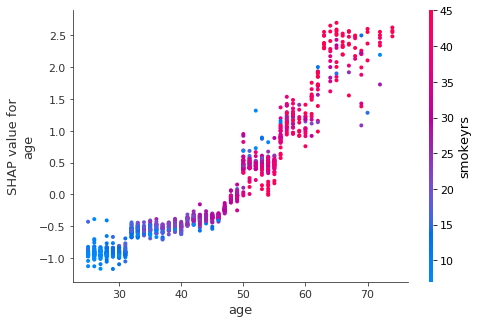

In [30]:
shap.dependence_plot(X_train.columns.get_loc('age'), shap_values, X_train)

# Custom SHAP plots

## SHAP dependence plot

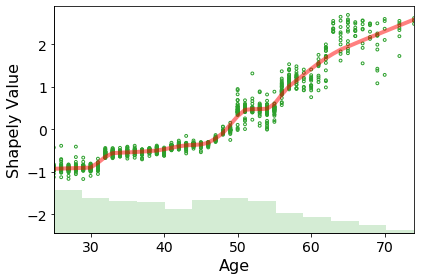

In [31]:
features = X_train
base_shap = explainer.expected_value
feat_text = 'Age'
feature_name = 'age'
shap_columns = None
shap_text = None
manual_bins = None
x_quantile_min = None
x_quantile_max = None
SZ = 16
color = sns.color_palette()[2]

dep_plot(feature_name=feature_name, shap_values=shap_values, features=features, shap_columns=shap_columns, ax=None,
         feature_text=feat_text, shap_text=shap_text,
         base_shap=base_shap, y_transform=None, add_nan=False, nan_label='NaN',
         x_min=None, x_max=None, x_round=None, manual_bins=manual_bins,
         x_quantile_min=x_quantile_min, x_quantile_max=x_quantile_max,
         plot_hist=True, plot_type='lowess',
         SZ=SZ, color=color, hist_color=color)

fig = plt.gcf()
fig.tight_layout()
fig.savefig(output_path / 'example_dep_plot.png')

## Categorical SHAP summary plot

In [32]:
shap_cats = get_shap_categories(shap_values=shap_values, features=X_train,
                                features_categories=data_desc, feat_col='Variable name', cat_col='Category')
shap_cats.head()

,Lifestyle,Base features,Medications,Diagnoses,Socioeconomic,Anthropometrics
0,-0.423516,-0.970752,-0.212135,-0.072405,-0.091140,0.001392
1,-0.210050,-0.992291,-0.194662,-0.072651,-0.081454,-0.279096
2,-0.510851,-0.943902,-0.311613,-0.075335,-0.090273,0.519103
3,-0.535428,-0.876868,0.080358,-0.046700,-0.146189,0.026524
4,0.451163,-0.378843,0.121775,-0.046109,-0.142892,0.056795


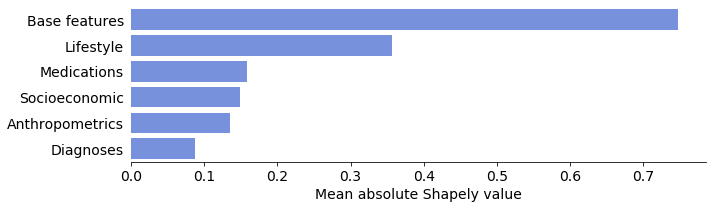

In [33]:
plot_shap_summary_bar(shap_cats, ax=None, sz=14)
fig = plt.gcf()
fig.tight_layout()
fig.savefig(output_path / 'example_summary_plot.png')

## SHAP dependence plot for sum of features in a category

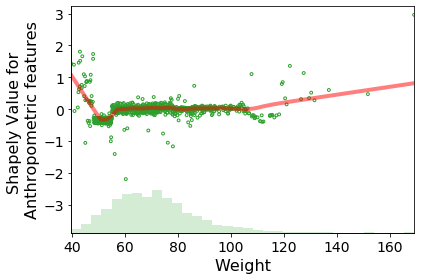

In [34]:
features = X_train
base_shap = explainer.expected_value
feat_text = 'Weight'
feature_name = 'wt71'
shap_columns = data_desc.loc[(data_desc['Category']=='Anthropometrics'), 'Variable name'].tolist()
shap_text = '\nAnthropometric features'
manual_bins = None
x_quantile_min = None
x_quantile_max = None
SZ = 16
color = sns.color_palette()[2]

dep_plot(feature_name=feature_name, shap_values=shap_values, features=features, shap_columns=shap_columns, ax=None,
         feature_text=feat_text, shap_text=shap_text,
         base_shap=base_shap, y_transform=None, add_nan=False, nan_label='NaN',
         x_min=None, x_max=None, x_round=None, manual_bins=manual_bins,
         x_quantile_min=x_quantile_min, x_quantile_max=x_quantile_max,
         plot_hist=True, plot_type='lowess',
         SZ=SZ, color=color, hist_color=color)

fig = plt.gcf()
fig.tight_layout()
fig.savefig(output_path / 'example_cat_dep_plot.png')